In [118]:
import os
import sys
import math
import logging
import glob
from pathlib import Path
import h5py

import numpy as np
import scipy as sp
import tensorflow as tf
import tensorflow_probability as tfp
import sklearn
import healpy as hp
import pymaster as nmt
from scipy.ndimage import gaussian_filter
from sklearn.manifold import TSNE

%load_ext autoreload
%autoreload 2

import PIL
import imageio
import matplotlib.pyplot as plt
#%config InlineBackend.figure_format = 'retina'

import seaborn as sns
sns.set_context("poster")
sns.set(rc={'figure.figsize': (16, 9.)})
sns.set_style("whitegrid")

import pandas as pd
pd.set_option("display.max_rows", 120)
pd.set_option("display.max_columns", 120)

import began
from began.visualization import mplot, plot
from began import stats

%matplotlib inline
logging.basicConfig(level=logging.INFO, stream=sys.stdout)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
np.random.seed(2984)
cfg = {}
with h5py.File("/home/bthorne/projects/gan/began/data/preprocessed/prepared.h5", "r") as f:
    dset = f["cut_maps"][...]
    cfg.update(f["cut_maps"].attrs)
rescaled_dset = tf.image.per_image_standardization(dset)
print(rescaled_dset.shape)
#dset = tf.data.Dataset.from_tensor_slices(dset).shuffle(1000).batch(9).map(tf.image.per_image_standardization)

Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
(1754, 256, 256, 1)


In [3]:
lat_dim = 256
kernel_size = 5 
model = began.CVAE(lat_dim, kernel_size)
model.load_weights("../models/vae.h5")


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



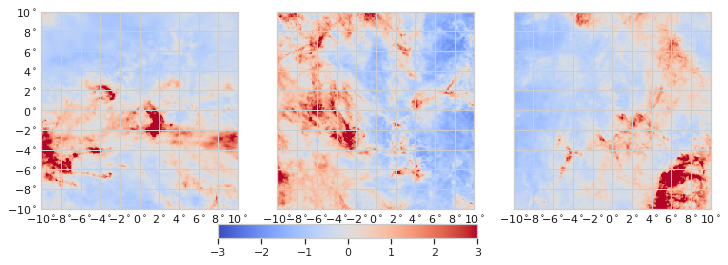

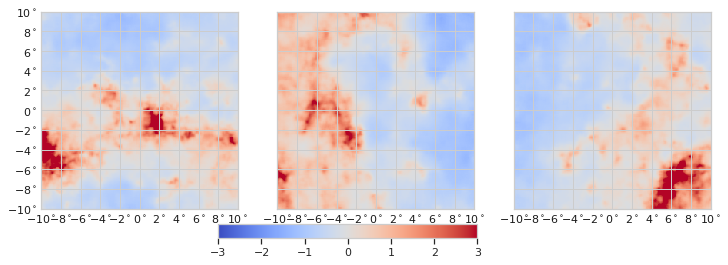

In [4]:
extent = (-cfg['ang_x'] / 2., cfg['ang_x'] / 2., -cfg['ang_y'] / 2., cfg['ang_y'] / 2.)

subset = rescaled_dset.numpy()[np.random.randint(0, rescaled_dset.shape[0], 3)]
subset = np.array([sub[::-1, ::-1, :1] for sub in subset])
mplot(subset[..., 0], cbar_range=[-3, 3], extent=extent);
mplot(model.decode(model.reparameterize(*model.encode(subset)))[..., 0], cbar_range=[-3, 3], extent=extent);

In [112]:
def get_l2_log_prob(ma, sigma, retjac=True):
    assert ma.ndim==4
    def log_prob(z):
        if retjac:
            with tf.GradientTape() as tape:
                tape.watch(z)
                genned_image = model.decode(z)
                loss_value = tf.math.reduce_sum((ma - genned_image)[0, :, :, 0] ** 2) - tf.math.reduce_sum(z ** 2)
            jac = tape.gradient(loss_value, z)
            loss_value = tf.reshape(loss_value, [1])
            return loss_value, jac
        else:
            genned_image = model.decode(z)
            loss_value = tf.math.reduce_sum((ma - genned_image)[0, :, :, 0] ** 2 / sigma ** 2) - tf.math.reduce_sum(z ** 2)
            return loss_value
    return log_prob

In [131]:
l2_opt = []
for sub in subset:
    logprob = get_l2_log_prob(sub[None, ...], 0.1)
    x = tf.Variable(np.random.randn(1, 256).astype(np.float32))
    l2_opt.append(tfp.optimizer.lbfgs_minimize(logprob, initial_position=x, max_iterations=200))

In [132]:
recovered = np.empty((len(l2_opt), cfg['xres'], cfg['yres'], 1))
recovered[0] = np.array(model.decode(l2_opt[0].position))
recovered[1] = np.array(model.decode(l2_opt[1].position))
recovered[2] = np.array(model.decode(l2_opt[2].position))


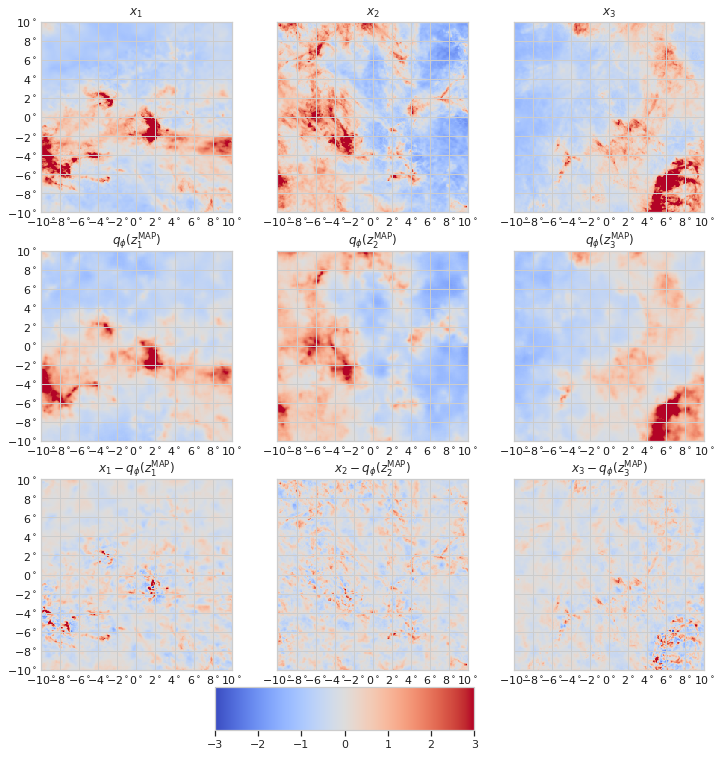

In [133]:
titles = [
    r"$x_1$",
    r"$x_2$",
    r"$x_3$",
    r"$q_\phi(z_1^{\rm MAP})$",
    r"$q_\phi(z_2^{\rm MAP})$",
    r"$q_\phi(z_3^{\rm MAP})$",
    r"$x_1 - q_\phi(z_1^{\rm MAP})$",
    r"$x_2 - q_\phi(z_2^{\rm MAP})$",
    r"$x_3 - q_\phi(z_3^{\rm MAP})$",
]

fig, ax = mplot(np.concatenate((subset, recovered, subset-recovered))[..., 0], titles=titles, cbar_range=[-3, 3], extent=extent, layout=(3, 3), figsize=(12, 12))
fig.savefig("../reports/figures/data-reconstruction-l2.png", bbox_inches='tight', dpi=400)

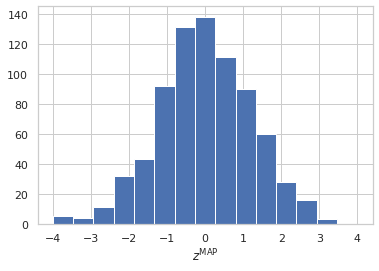

In [138]:
fig, ax = plt.subplots(1, 1)
zs = np.concatenate([z.position.numpy() for z in l2_opt]).flatten()
ax.hist(zs, range=[-4, 4], bins=15)
ax.set_xlabel(r"$z^{\rm MAP}$")
fig.savefig("../reports/figures/l2-max-latent-space-hist.png", bbox_inches='tight', dpi=400)

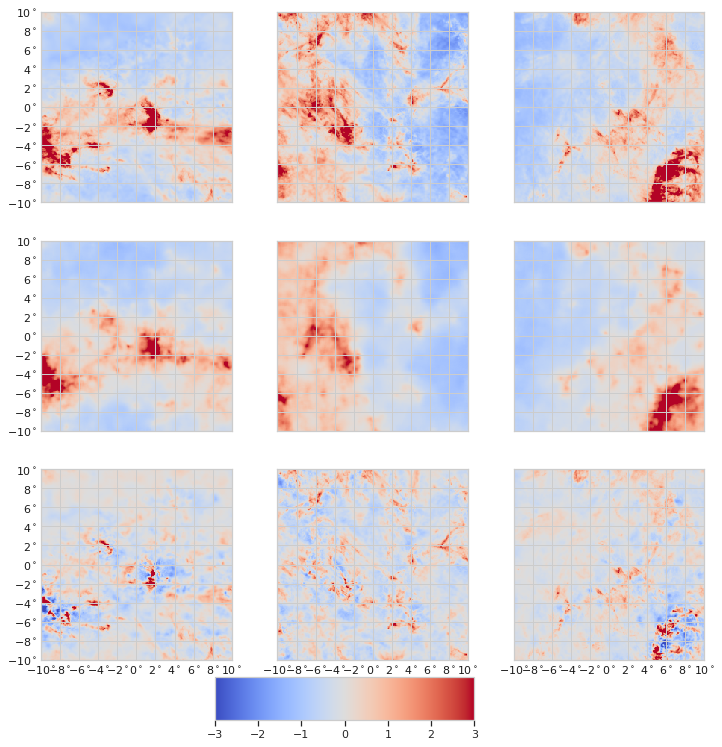

In [135]:
recoding = model.decode(model.reparameterize(*model.encode(subset)))
mplot(np.concatenate((subset, recoding, subset-recoding))[...,0], extent=extent, cbar_range=[-3, 3]);

In [5]:
A = np.ones((cfg['xres'], cfg['yres']))
masks = []
patches = [
    ((10, 100), (10, 100)),
    ((125, 200), (10, 100)),
    ((10, 200), (150, 250)),
]
for (xinds, yinds) in patches:
    B = np.copy(A)
    B[xinds[0]: xinds[1], yinds[0]:yinds[1]] = 0
    masks.append(B)

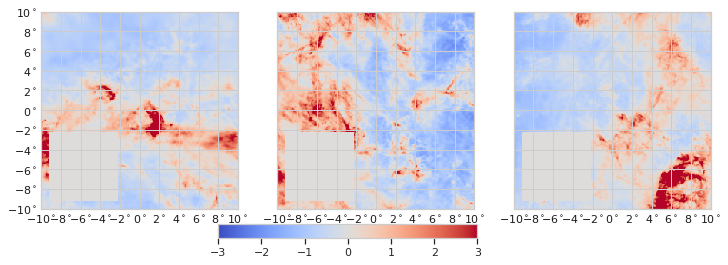

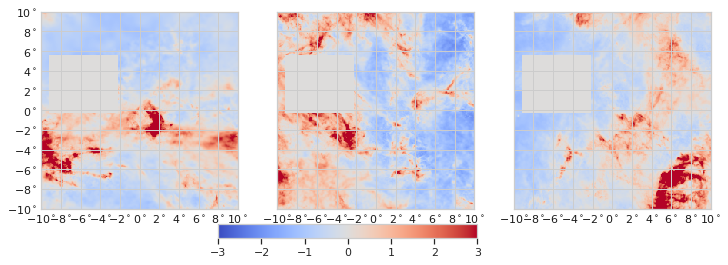

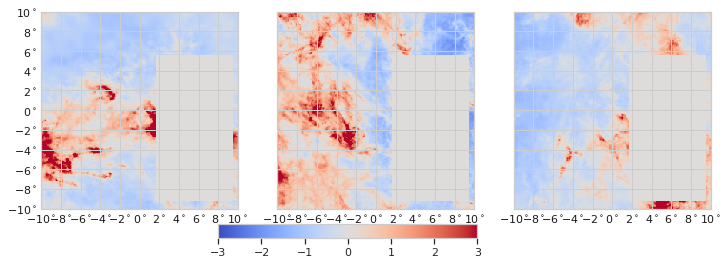

In [6]:
for A in masks:
    mplot(A[None, ...] * subset[..., 0], cbar_range=[-3, 3], extent=extent)
    #mplot(subset[..., 0], cbar_range=[-3, 3], extent=extent)

In [90]:
def get_log_prob(mask, ma, sigma, retjac=True):
    assert ma.ndim==4
    def log_prob(z):
        if retjac:
            with tf.GradientTape() as tape:
                tape.watch(z)
                genned_image = model.decode(z)
                loss_value = tf.math.reduce_sum((ma - genned_image)[0, :, :, 0][mask] ** 2 / sigma ** 2) - tf.math.reduce_sum(z ** 2)
            jac = tape.gradient(loss_value, z)
            loss_value = tf.reshape(loss_value, [1])
            return loss_value, jac
        else:
            genned_image = model.decode(z)
            loss_value = tf.math.reduce_sum((ma - genned_image)[0, :, :, 0][mask] ** 2 / sigma ** 2) - tf.math.reduce_sum(z ** 2)
            return loss_value
    return log_prob

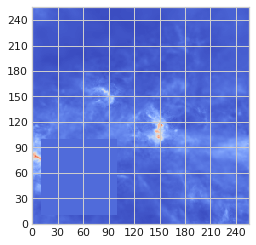

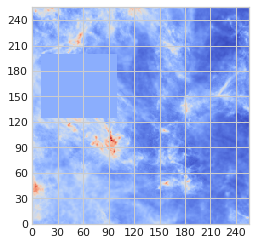

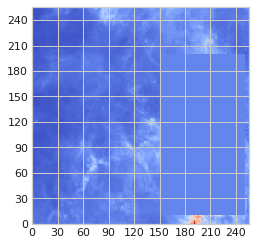

In [91]:
bin_opt = []
for mask, sub in zip(masks, subset):
    plot((mask[None, ...] * sub[..., 0])[0])
    masked = mask[None, ...].astype(int) * sub[..., 0]
    logprob = get_log_prob(mask.astype(bool), sub[None, ...], 0.01)
    x = tf.Variable(np.random.randn(1, 256).astype(np.float32))
    bin_opt.append(tfp.optimizer.lbfgs_minimize(logprob, initial_position=x, max_iterations=200))

In [92]:
recovered = np.empty((len(bin_opt), cfg['xres'], cfg['yres'], 1))
recovered[0] = np.array(model.decode(bin_opt[0].position))
recovered[1] = np.array(model.decode(bin_opt[1].position))
recovered[2] = np.array(model.decode(bin_opt[2].position))
masked = np.array([mask.astype(float) * sub[..., 0] for mask, sub in zip(masks, subset)])[..., None]

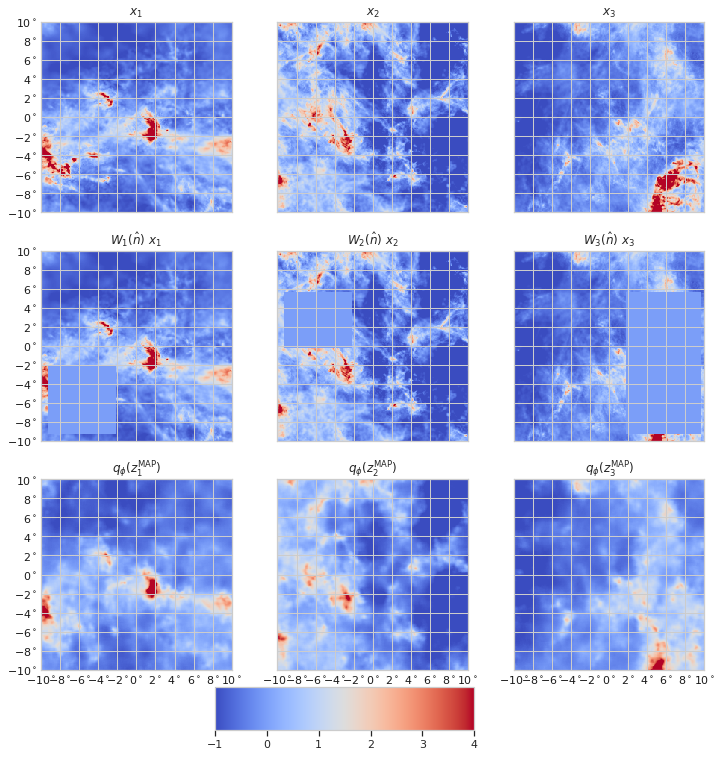

In [93]:
titles = [
    r"$x_1$",
    r"$x_2$",
    r"$x_3$",
    r"$W_1(\hat n)~x_1$",
    r"$W_2(\hat n)~x_2$",
    r"$W_3(\hat n)~x_3$",
    r"$q_\phi(z_1^{\rm MAP})$",
    r"$q_\phi(z_2^{\rm MAP})$",
    r"$q_\phi(z_3^{\rm MAP})$",
]

fig, ax = mplot(np.concatenate((subset, masked, recovered))[..., 0], titles=titles, cbar_range=[-1, 4], extent=extent)
fig.savefig("../reports/figures/data-imputation-binary-mask.png", bbox_inches='tight', dpi=400)

In [55]:
def gauss_get_log_prob(mask, ma, sigma, gauss_kernel, retjac=True):
    assert ma.ndim==4
    def log_prob(z):
        if retjac:
            with tf.GradientTape() as tape:
                tape.watch(z)
                genned_image = model.decode(z)
                loss_value = tf.math.reduce_sum((ma - tf.nn.conv2d(genned_image, gauss_kernel, strides=[1, 1, 1, 1], padding='SAME'))[0, :, :, 0][mask] ** 2 / sigma ** 2) - tf.math.reduce_sum(z ** 2)
            jac = tape.gradient(loss_value, z)
            loss_value = tf.reshape(loss_value, [1])
            return loss_value, jac
        else:
            genned_image = model.decode(z)
            loss_value = tf.math.reduce_sum((ma -tf.nn.conv2d(genned_image, gauss_kernel, strides=[1, 1, 1, 1], padding='SAME'))[0, :, :, 0][mask] ** 2 / sigma ** 2) - tf.math.reduce_sum(z ** 2)
            return loss_value
    return log_prob

In [29]:
def gaussian_kernel(size: int, mean: float, std: float):
    """ Makes 2D gaussian Kernel for convolution.
    """
    d = tfp.distributions.Normal(mean, std)
    vals = d.prob(tf.range(start = -size, limit = size + 1, dtype = tf.float32))
    gauss_kernel = tf.einsum('i,j->ij', vals, vals)
    return gauss_kernel / tf.reduce_sum(gauss_kernel)

In [80]:
# Make Gaussian Kernel with desired specs.
gauss_kernel = gaussian_kernel(5, 0, 5)

# Expand dimensions of `gauss_kernel` for `tf.nn.conv2d` signature.
gauss_kernel = gauss_kernel[:, :, tf.newaxis, tf.newaxis]
sigma = 0.2
# Convolve.
out = tf.nn.conv2d(subset, gauss_kernel, strides=[1, 1, 1, 1], padding="SAME")
out += np.random.randn(3, 256, 256, 1) * sigma

mplot(out[..., 0])

In [81]:
gauss_opt = []
for sub in out:
    logprob = gauss_get_log_prob(np.ones(cfg['xres'], cfg['yres']).astype(bool), sub[None, ...], 0.5, gauss_kernel)
    x = tf.Variable(np.random.randn(1, 256).astype(np.float32))
    gauss_opt.append(tfp.optimizer.lbfgs_minimize(logprob, initial_position=x, max_iterations=200))

In [82]:
recovered = np.empty((len(gauss_opt), cfg['xres'], cfg['yres'], 1))
recovered[0] = np.array(model.decode(gauss_opt[0].position))
recovered[1] = np.array(model.decode(gauss_opt[1].position))
recovered[2] = np.array(model.decode(gauss_opt[2].position))

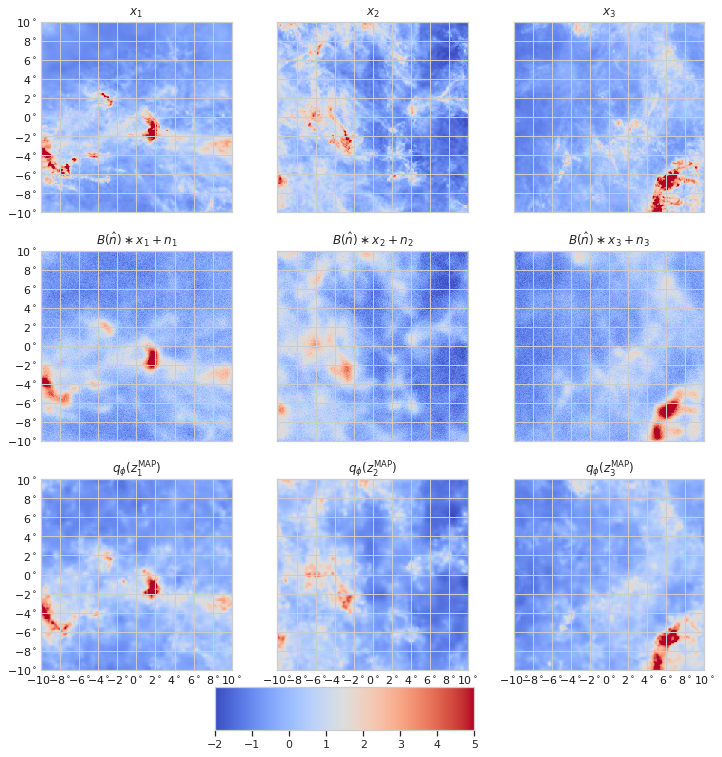

In [86]:
titles = [
    r"$x_1$",
    r"$x_2$",
    r"$x_3$",
    r"$B(\hat n)\ast x_1 + n_1$",
    r"$B(\hat n)\ast x_2 + n_2$",
    r"$B(\hat n)\ast x_3 + n_3$",
    r"$q_\phi(z_1^{\rm MAP})$",
    r"$q_\phi(z_2^{\rm MAP})$",
    r"$q_\phi(z_3^{\rm MAP})$",
]

fig, ax = mplot(np.concatenate((subset, out, recovered))[..., 0], titles=titles, extent=extent, cbar_range=[-2., 5]);
fig.savefig("../reports/figures/data-imputation-gaussian-noise.png", bbox_inches='tight', dpi=400)

(array([ 0.,  3.,  3.,  7., 18., 26., 44., 44., 46., 39., 15.,  7.,  2.,
         2.,  0.]),
 array([-4.        , -3.4666667 , -2.9333334 , -2.4       , -1.8666667 ,
        -1.3333334 , -0.8       , -0.26666668,  0.26666668,  0.8       ,
         1.3333334 ,  1.8666667 ,  2.4       ,  2.9333334 ,  3.4666667 ,
         4.        ], dtype=float32),
 <a list of 15 Patch objects>)

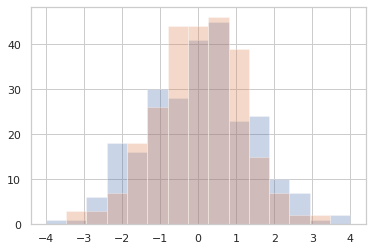

In [110]:
fig, ax = plt.subplots(1, 1)
plt.hist(opt[0].position.numpy().flatten(), range=[-4, 4], alpha=0.3, bins=15)
plt.hist(bin_opt[0].position.numpy().flatten(), range=[-4, 4], alpha=0.3, bins=15)

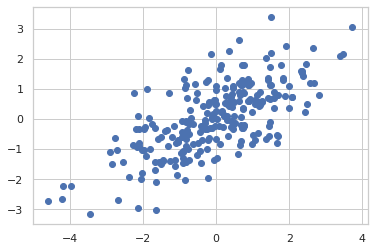

In [104]:
plt.scatter(opt[0].position.numpy().flatten(), bin_opt[0].position.numpy().flatten())

In [106]:
print(opt[0].position.numpy().flatten()[:4])
print(bin_opt[0].position.numpy().flatten()[:4])

[-0.53762555  2.6398618   0.4566061   2.3764138 ]
[ 0.63922775  2.3696861  -0.31885874  1.4346957 ]


In [38]:
# Initialize the HMC transition kernel.
lnprob = get_log_prob(mask, subset[1:2], 0.01, retjac=False)
num_results = int(10e3)
num_burnin_steps = int(1e3)
adaptive_hmc = tfp.mcmc.SimpleStepSizeAdaptation(
    tfp.mcmc.HamiltonianMonteCarlo(
        target_log_prob_fn=lnprob,
        num_leapfrog_steps=3,
        step_size=1.),
    num_adaptation_steps=int(num_burnin_steps * 0.8))

In [ ]:
# Run the chain (with burn-in).
@tf.function
def run_chain():
    # Run the chain (with burn-in).
    samples, is_accepted = tfp.mcmc.sample_chain(
      num_results=num_results,
      num_burnin_steps=num_burnin_steps,
      current_state=np.random.randn(1, 256).astype(np.float32),
      kernel=adaptive_hmc,
      trace_fn=lambda _, pkr: pkr.inner_results.is_accepted)
    sample_mean = tf.reduce_mean(samples)
    sample_stddev = tf.math.reduce_std(samples)
    is_accepted = tf.reduce_mean(tf.cast(is_accepted, dtype=tf.float32))
    return sample_mean, sample_stddev, is_accepted

In [ ]:
sample_mean, sample_stddev, is_accepted = run_chain()

print('mean:{:.4f}  stddev:{:.4f}  acceptance:{:.4f}'.format(
    sample_mean.numpy(), sample_stddev.numpy(), is_accepted.numpy()))